<a href="https://colab.research.google.com/github/mnansary/pyF2O/blob/master/colab_gen_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# colab specific task
*   Check TF version
*   mount google drive
*   GPU check
*   Change Working Directory to cloned dir 

NOTE: **git clone the repo before running this notebook**

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.__version__


TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


'2.0.0'

In [3]:
cd /content/gdrive/My\ Drive/PROJECTS/F2O/pyF2O/

/content/gdrive/My Drive/PROJECTS/F2O/pyF2O


# GCS specific task 
* **auth user**
* set project information


In [0]:
# auth user for cloud SDK
from google.colab import auth
auth.authenticate_user()

#### SET PROJECT INFORMATION 

In [5]:
PROJECT_ID    ='record-1106154'               # @param 
BUCKET        ='tfalldata'               # @param 

# LIST FILES
TFRECORDS_DIR = 'gs://{}/{}/'.format(BUCKET,'tfrecord')
CHECKPOINT_DIR= 'gs://{}/{}/'.format(BUCKET,'checkpoints')

!gcloud config set project {PROJECT_ID}
!gsutil ls {TFRECORDS_DIR}
!gsutil ls gs://{BUCKET}

Updated property [core/project].
gs://tfalldata/tfrecord/test/
gs://tfalldata/tfrecord/train/
gs://tfalldata/checkpoints/
gs://tfalldata/tfrecord/


# pix2pix
* Define **FLAGS**  
* Check **train and test dataset**
* Define **Optimizers**  
* Define **Checkpoint-saver**
* Define **Train Step**

#### FLAGS

In [0]:
class FLAGS:
    IMAGE_DIM       = 256     #@param
    NB_CHANNELS     = 3       #@param
    BATCH_SIZE      = 1     #@param
    SHUFFLE_BUFFER  = 672     #@param

LEARNING_RATE   = 2e-4    #@param
EPOCHS          = 150     #@param  
BETA            = 0.5     #@param
SAVE_COUNT      = 50      #@param
RESTORE         = True   #@param
SIG             = 7       #@param

#### DataSets
 

In [7]:
import os
from glob import glob
from google.cloud import storage

client = storage.Client(PROJECT_ID)
# get bucket from the project
bucket=client.get_bucket(BUCKET)
print(bucket)

def data_input_fn(FLAGS,mode): 
    
    def _parser(example):
        feature ={  'image'  : tf.io.FixedLenFeature([],tf.string) ,
                    'target' : tf.io.FixedLenFeature([],tf.string)
        }    
        parsed_example=tf.io.parse_single_example(example,feature)
        image_raw=parsed_example['image']
        image=tf.image.decode_png(image_raw,channels=FLAGS.NB_CHANNELS)
        image=tf.cast(image,tf.float32)/255.0
        image=tf.reshape(image,(FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS))
        
        target_raw=parsed_example['target']
        target=tf.image.decode_png(target_raw,channels=FLAGS.NB_CHANNELS)
        target=tf.cast(target,tf.float32)/255.0
        target=tf.reshape(target,(FLAGS.IMAGE_DIM,FLAGS.IMAGE_DIM,FLAGS.NB_CHANNELS))
        return image,target

    dataset = tf.data.TFRecordDataset([os.path.join('gs://{}/'.format(BUCKET), 
                                                    f.name) for f in bucket.list_blobs(prefix='tfrecord/{}'.format(mode))])
    dataset = dataset.map(_parser)
    if mode=='train':
      dataset = dataset.shuffle(FLAGS.SHUFFLE_BUFFER,reshuffle_each_iteration=True)
    dataset = dataset.batch(FLAGS.BATCH_SIZE,drop_remainder=True)
    return dataset


train_ds = data_input_fn(FLAGS,'train')
for example_input, example_target in train_ds.take(1):
  print(example_input.shape)
test_ds = data_input_fn(FLAGS,'test')



<Bucket: tfalldata>
(1, 256, 256, 3)


#### Optimizers,Checkpoint,Summary
 

In [0]:
from F2O.networks import Generator,Discriminator
# optimizers
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE,
                                               beta_1=BETA)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE,
                                                   beta_1=BETA)
# Models
generator=Generator(IMAGE_DIM=FLAGS.IMAGE_DIM,
                    NB_CHANNELS=FLAGS.NB_CHANNELS)
discriminator=Discriminator(IMAGE_DIM=FLAGS.IMAGE_DIM,
                    NB_CHANNELS=FLAGS.NB_CHANNELS)
# checkpoint
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


#### Train Step

In [0]:
from F2O.networks import generator_loss,discriminator_loss
import numpy as np 

GEN_TOTAL_LOSS_EPOCH=[]
GEN_GAN_LOSS_EPOCH=[]
GEN_L1_LOSS_EPOCH=[]
DISC_LOSS_EPOCH=[]
class LOSS_SUM:
  GEN_TOTAL_LOSS_SUM=0
  GEN_GAN_LOSS_SUM=0
  GEN_L1_LOSS_SUM=0
  DISC_LOSS_SUM=0

@tf.function
def train_step(input_image, target, epoch,VAL,LOSS_SUM=LOSS_SUM):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  if VAL==FLAGS.SHUFFLE_BUFFER-1:
    tf.print('GEN_TOTAL_LOSS:',gen_total_loss,end='')
    tf.print('  GEN_GAN_LOSS:',gen_gan_loss,end='')
    tf.print('  GEN_L1_LOSS:',gen_l1_loss,end='')         
    tf.print('  DISC_LOSS:',disc_loss)          
    
                                                                                    

#### Training loop



In [0]:
import time

if RESTORE:
  checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

def fit(train_ds, epochs, test_ds):
  for epoch in range(1,epochs+1):
    start = time.time()
    # Train
    print("Epoch:{}|".format(epoch),end='')
    for n, (input_image, target) in train_ds.enumerate():
      if n % SIG==0 and n<FLAGS.SHUFFLE_BUFFER-1:
        print('>',end='')
      elif n==FLAGS.SHUFFLE_BUFFER-1:
        print('>|')
      train_step(input_image, target, epoch,n)
  
    # saving (checkpoint) 
    if (epoch) % SAVE_COUNT == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time taken for epoch {} is {} sec'.format(epoch,time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)


In [11]:
fit(train_ds, EPOCHS, test_ds)

Epoch:1|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|
GEN_TOTAL_LOSS: 2.514606  GEN_GAN_LOSS: 0.454667777  GEN_L1_LOSS: 0.020599382  DISC_LOSS: 1.27014887
Time taken for epoch 1 is 58.87042260169983 sec
Epoch:2|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|
GEN_TOTAL_LOSS: 3.45115423  GEN_GAN_LOSS: 2.24709535  GEN_L1_LOSS: 0.0120405881  DISC_LOSS: 0.738959908
Time taken for epoch 2 is 46.20321488380432 sec
Epoch:3|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|
GEN_TOTAL_LOSS: 4.45174  GEN_GAN_LOSS: 1.64475834  GEN_L1_LOSS: 0.0280698147  DISC_LOSS: 0.390520364
Time taken for epoch 3 is 45.97415828704834 sec
Epoch:4|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>|
GEN_TOTAL_LOSS: 3.11667633  GEN_GAN_LOSS: 1.7214278  GEN_L1_LOSS: 0.0139524862  DISC_LOSS: 0.369860381
Time taken for epoc

#### Restore Checkpoint

In [12]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

#### Prediction Example

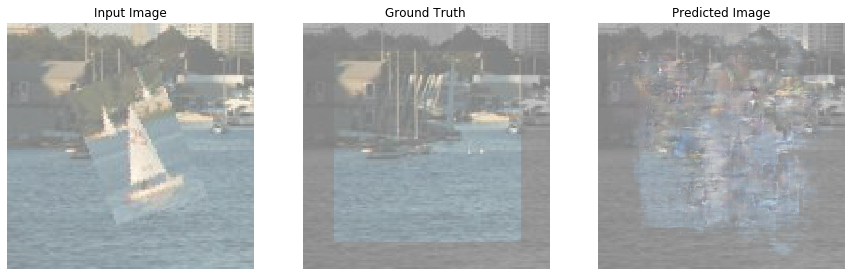

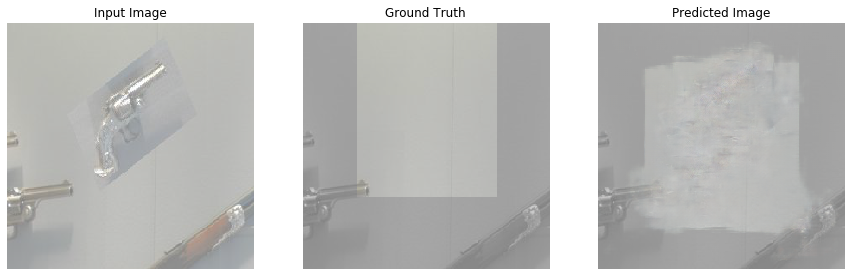

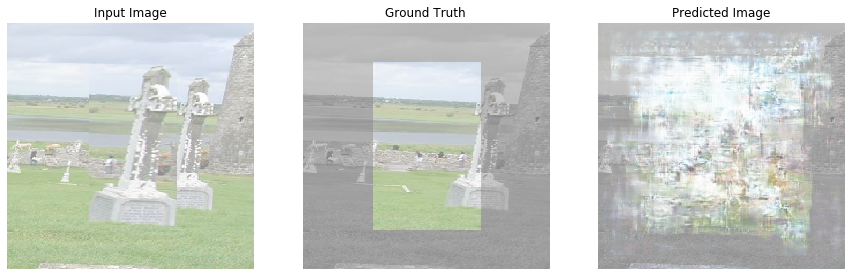

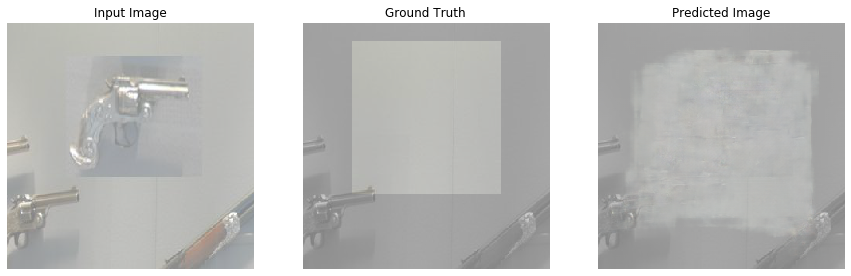

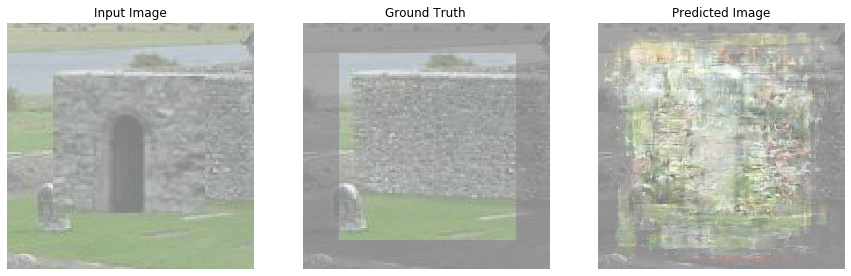

In [13]:
from matplotlib import pyplot as plt
from IPython import display
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
# Run the trained model on a few examples from the test dataset
for inp, tar in test_ds.take(5):
  generate_images(generator, inp, tar)